In [33]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from win32com import client
app = client.dynamic.Dispatch('designer.Application')
study =app.GetCurrentStudy()
model = app.GetCurrentModel()
ssel = model.CreateSelection()
d = app.CreateDialogBox()
def Periodicity(targetStudy):
	periodic=1
	NumberOfConditions=targetStudy.NumConditions()
	
	for i in range(NumberOfConditions):
		if targetStudy.GetCondition(i).GetScriptTypeName()=="RotationPeriodicBoundary":
			periodic=360/int(targetStudy.GetCondition(i).GetValue(u"Angle"))
	return(periodic)


In [23]:
def spatialmode(n,slot):

	study =app.GetCurrentStudy()
	allsteps=study.GetStep().GetValue(u'Step')
	#print study.GetStep().GetValue(u'EndPoint')
	#print study.GetStep().GetValue(u'StepDivision')
	thickness=study.GetStudyProperties().GetValue("ModelThickness")
	prio=Periodicity(study)
	nteeth=slot/prio
	pname=u'Tooth_'+str(1)
	nn=n   
	for p in reversed(app.GetDataManager().GetAllNames()):
	#	print p
		if p == pname or  p == pname+'_fft':
			app.GetDataManager().DeleteDataSetObject(app.GetDataManager().GetDataSet(p))

	nfor_res=np.zeros((int(allsteps),int(nteeth+1)))
	nfft=2**np.fix(np.log(allsteps)/np.log(2))
	nfor_fft=np.zeros((int(nfft),int(nteeth+1)))

	for jj in range(1,int(nteeth+1)):
		pname=u'Tooth_'+str(jj)
		for p in app.GetDataManager().GetAllNames():
			#print p
			if p == pname or  p == pname+'_fft':
				app.GetDataManager().DeleteDataSetObject(app.GetDataManager().GetDataSet(p))
		study.CreateEdgeCalculationDefinition(pname)
		study.GetCalculationDefinition(pname).SetResultType(u"NodalForce", u"")
		study.GetCalculationDefinition(pname).SetResultCoordinate(u"Cylindrical")
		study.GetCalculationDefinition(pname).SetComponent(u"Radial")
		study.GetCalculationDefinition(pname).SetCalculationType(u"sum")
		study.GetCalculationDefinition(pname).ClearParts()
		study.GetCalculationDefinition(pname).AddSet(model.GetSetList().GetSet(pname), 2)
		yy=app.GetDataManager().GetDataSet(pname)
		tstep=yy.GetValue(1, 0)-yy.GetValue(0, 0)
		rrow=int(allsteps)
		for i in range(rrow):
			nfor_res[i,0]=yy.GetValue(i, 0)
			nfor_res[i,jj]=yy.GetValue(i, 1)*thickness/1000



		rrow=app.GetDataManager().GetDataSet(pname).GetRows()
		yy=app.GetDataManager().GetDataSet(pname)
		estep=yy.GetValue(rrow-1, 0)
#		print estep
	
		ref1 = app.GetDataManager().GetDataSet(pname)
		parameter = app.CreateFFTParameter(pname+"_fft")
		parameter.SetDataSet(ref1)
		parameter.SetSeries(0)
		parameter.SetType(u"RealAndImaginary")
		parameter.SetMin(u"0")
		parameter.SetMax(str(estep))
		parameter.SetDBMultiplier(20)
		parameter.SetCreateGraph(True)
		parameter.SetAxisType(u"Time")
		app.GetDataManager().CreateFFTWithParameter(parameter)

		study.DeleteCalculationDefinition(pname)

		fre_estep=app.GetDataManager().GetDataSet(pname+"_fft").GetRows()
		yy=app.GetDataManager().GetDataSet(pname+"_fft")
		for i in range(1,fre_estep):
			nfor_fft[i-1,0]=yy.GetValue(i, 0)

			nfor_fft[i-1,jj]=yy.GetValue(i, 1)*thickness/1000
#			print yy.GetValue(i, 1),'  ',nfor_fft[i-1,jj]
#		print fre_estep
    

	#print nfor_fft.shape
	plt.figure(2,figsize=(10,8))

	for kk in range(1,int(nn+1)):
		plt.gcf()
		gg=np.append(np.tile(nfor_fft[int(kk-1),1:],(1,int(prio))),nfor_fft[int(kk-1),1])
		plt.polar(np.linspace(0,2*np.pi,slot+1),gg,linewidth=2)
		plt.legend(['#%s frequency' % (pp) for pp in range(1,int(nn+1))])
		plt.yticks(np.linspace(np.min(gg)*1.5,np.max(gg)*1.5,5))
		plt.grid('on')
 		plt.title(u"The Spatial Mode of Force", va='bottom',fontproperties='Malgun Gothic',fontsize='14')
#np.savetxt(u'd:/aaa.csv',np.transpose(np.tile(nfor_fft[:,1:nn+1],(1,prio))),delimiter=',')


In [24]:
slot=24
inradi=23.9
init_ang=0
tol=0.05
check_tee=1 #d.GetValue("check_tee")
spamode=1
norder=11
#csvfilename=d.GetValue("csvfilename")


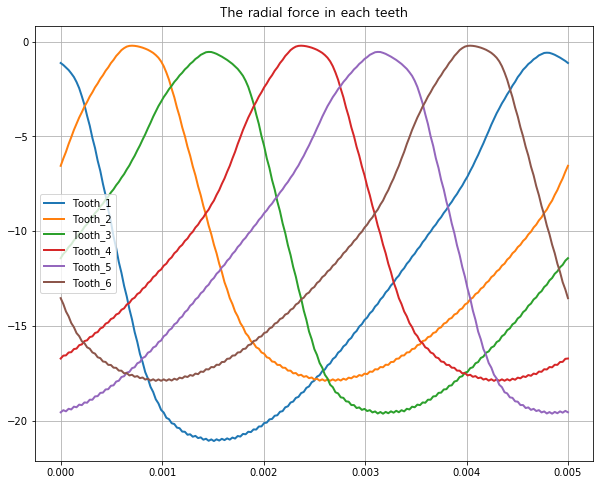

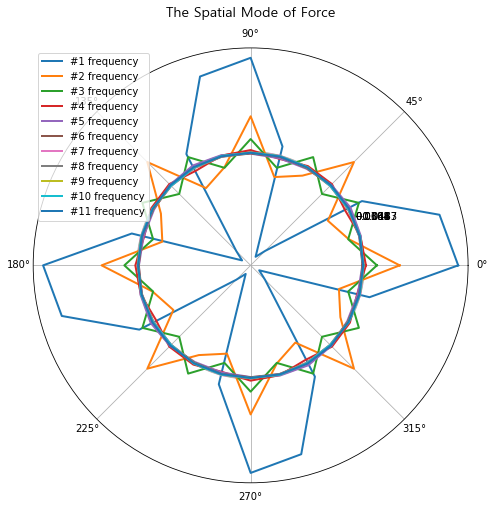

In [25]:
pangle=360./Periodicity(study)  
ndupli=Periodicity(study)  
nforce=int(pangle/(360./slot))
#print nforce
allsteps=study.GetStep().GetValue(u'Step')
nfor_res=np.zeros((int(allsteps),int(nforce+1)))
thickness=study.GetStudyProperties().GetValue("ModelThickness")

####
ListSet=model.GetSetList()
NumberOfSets=ListSet.NumSet()
Edge_List=[]
for i in range(NumberOfSets,0,-1):
	Set_temp=ListSet.GetSet(i)
	if Set_temp.GetType()=='Edge':
	#print Set_temp.GetName()
	#app.Sleep(30)
		if Set_temp.GetName().startswith('Tooth'):
			ListSet.DeleteSet(Set_temp.GetName())


for i in range(1,nforce+1):
#		print 'Tooth_'+str(i)
	if i==1:
		ssel.Clear()
		cyl1 = app.CreateCylinder()
		cyl1.SetCenterPoint(0, 0, 0)
		cyl1.SetCenterAxis(0, 0, 1)
		cyl1.SetInnerRadius(inradi-tol)
		cyl1.SetOuterRadius(inradi+tol)
		cyl1.SetUseHeight(False)
		cyl1.SetUseAngle(True)
		cyl1.SetXAxis(0, -1, 0)
		cyl1.SetStartAngle(90-360./slot/2+init_ang)
		cyl1.SetEndAngle(90+360./slot/2+init_ang)


		edgename='Tooth_'+str(i)
		model.GetSetList().CreateEdgeSet(edgename)
		model.GetSetList().GetSet(edgename).SetMatcherType("Selection")
		model.GetSetList().GetSet(edgename).ClearParts()
		#
		ssel.SelectEdgeByCylinderObject(cyl1,1)

		if check_tee==1:
			cyl2 = app.CreateCylinder()
			cyl2.SetCenterPoint(0, 0, 0)
			cyl2.SetCenterAxis(0, 0, 1)
			cyl2.SetInnerRadius(inradi-tol)
			cyl2.SetOuterRadius(inradi+tol)
			cyl2.SetUseHeight(False)
			cyl2.SetUseAngle(True)
			cyl2.SetXAxis(1, 0, 0)
			cyl2.SetStartAngle(pangle-360./slot/2+init_ang)
			cyl2.SetEndAngle(pangle+360./slot/2+init_ang)
			ssel.SelectEdgeByCylinderObject(cyl2,1)
		model.GetSetList().GetSet(edgename).AddSelected(ssel)
		ssel.Clear()
	else:
		ssel.Clear()
		cyl1 = app.CreateCylinder()
		cyl1.SetCenterPoint(0, 0, 0)
		cyl1.SetCenterAxis(0, 0, 1)
		cyl1.SetInnerRadius(inradi-tol)
		cyl1.SetOuterRadius(inradi+tol)
		cyl1.SetUseHeight(False)
		cyl1.SetUseAngle(True)
		cyl1.SetXAxis(1, 0, 0)
		cyl1.SetStartAngle(360./slot*(i-1)-360./slot/2+init_ang)
		cyl1.SetEndAngle(360./slot*(i-1)+360./slot/2+init_ang)
		#print 360./slot*(i-1)-360./slot/2,' ',360./slot*(i-1)+360./slot/2


		edgename='Tooth_'+str(i)
		model.GetSetList().CreateEdgeSet(edgename)
		model.GetSetList().GetSet(edgename).SetMatcherType("Selection")
		model.GetSetList().GetSet(edgename).ClearParts()
		#
		ssel.SelectEdgeByCylinderObject(cyl1,1)
		model.GetSetList().GetSet(edgename).AddSelected(ssel)
		ssel.Clear()
			

	pname=edgename #u'Tooth_'+str(i)
	study.CreateEdgeCalculationDefinition(pname)
	study.GetCalculationDefinition(pname).SetResultType(u"NodalForce", u"")
	study.GetCalculationDefinition(pname).SetResultCoordinate(u"Cylindrical")
	study.GetCalculationDefinition(pname).SetComponent(u"Radial")
	study.GetCalculationDefinition(pname).SetCalculationType(u"sum")
	study.GetCalculationDefinition(pname).ClearParts()
	study.GetCalculationDefinition(pname).AddSet(model.GetSetList().GetSet(pname), 2)

	rrow=app.GetDataManager().GetDataSet(pname).GetRows()

	yy=app.GetDataManager().GetDataSet(pname)

	for ii in range(rrow):
		nfor_res[ii,0]=yy.GetValue(ii, 0)
		nfor_res[ii,i]=yy.GetValue(ii, 1)*thickness/1000

#	print yy.GetValue(i,0),' ',yy.GetValue(i,1)
	study.DeleteCalculationDefinition(pname)
#print nfor_res[:2,:]
plt.figure(1,figsize=(10,8))
ax = plt.subplot(111)
ax.plot(nfor_res[:,0],nfor_res[:,1:],linewidth=2)
plt.grid('on')
plt.legend(['Tooth_%s'% str(s) for s in range(1,nforce+1)])
ax.set_title(u"The radial force in each teeth", va='bottom',fontproperties='Malgun Gothic',fontsize='14')
if spamode==1:
	spatialmode(norder,slot)
plt.show()


In [73]:
prio=Periodicity(study)
allforce=np.tile(nfor_res[:,1:],(1,int(prio)))

In [78]:
cfft=abs(np.fft.fft2(allforce)/allforce.size)
C=np.fft.fftshift(cfft)
C[C<0.1]=0

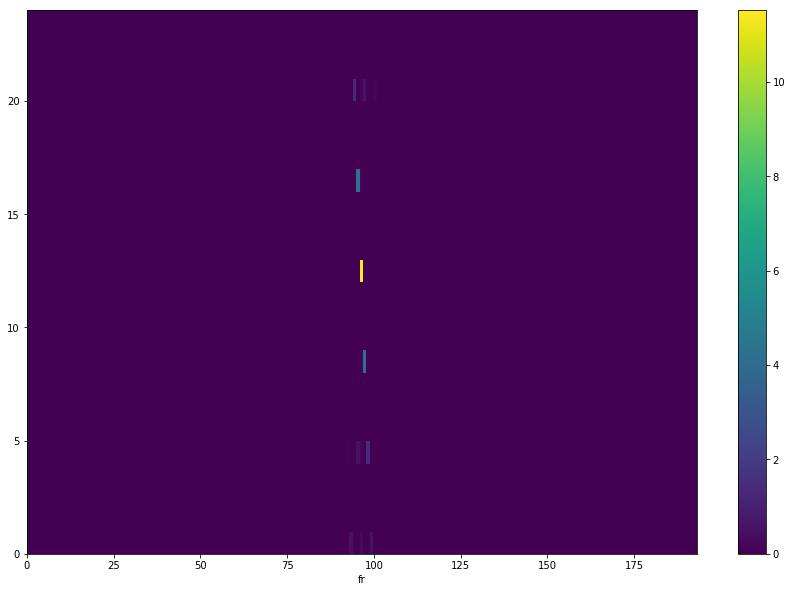

In [81]:
m,n=C.shape
#norder=20#np.min((int(m/2),int(n/2)))
#kk=(np.fft.fftshift((np.real(np.fft.fft2(C))/C.size)))
#xq=np.arange(-norder,+norder,1)
#yq=np.arange(-norder,+norder,1)
#k=kk[int(m/2)-norder:int(m/2)+norder,int(n/2)-norder:int(n/2)+norder]
k=C.T
#plt.matshow(k)
#k=np.ma.masked_where(k<0.1,k)
p=k
fig, ac = plt.subplots()
plt.pcolor(p)
fig.set_size_inches((15,10))
#ac.set_xticks(np.arange(int(xq.size))+0.5)
#ac.set_xticklabels(xq)
#ac.set_yticks(np.arange(int(yq.size))+0.5)
#ac.set_yticklabels(yq)
plt.xlabel('fr')
colorbar()

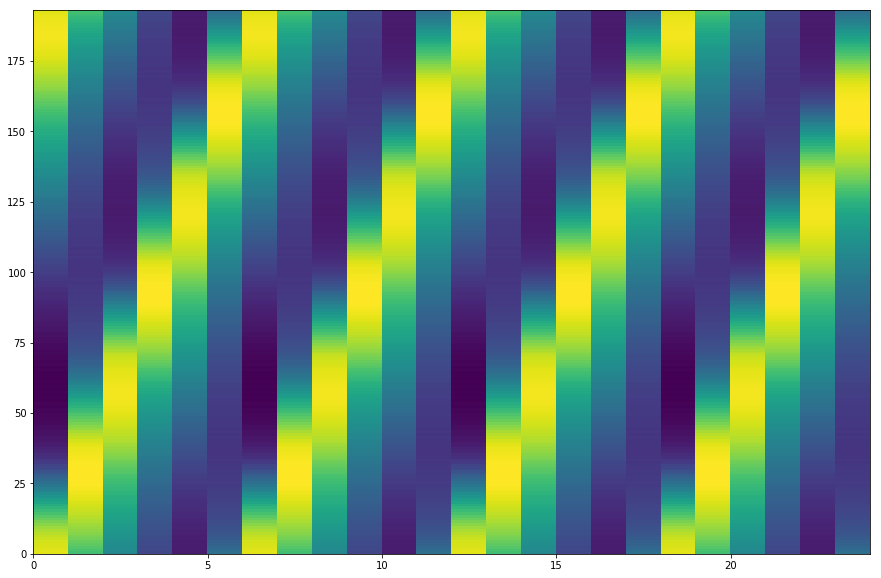

In [57]:
fig, ac = plt.subplots()
plt.pcolor(allforce)
fig.set_size_inches((15,10))